# fastai Multi Core TPU Training Example (Multi Label)

## Installation and Setup

Downgrade from pytorch 1.8 (colab default) and install pytorch 1.7.1 because fastai (as of 2.2.7) doesn't support pytorch 1.8 as of yet.

In [ ]:
!pip install -qqq --no-cache-dir torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchtext==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 735.4MB 1.1MB/s 
     |████████████████████████████████| 12.8MB 38.2MB/s 
     |████████████████████████████████| 7.0MB 6.8MB/s 


Install latest fastai (2.2.7)

In [ ]:
!pip install -Uqq fastai --upgrade

     |████████████████████████████████| 194kB 5.3MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 


Setup colab directories to show downloaded fastai data and models

In [ ]:
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


Install pytorch-xla 1.7

In [ ]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 31kB/s 
     |████████████████████████████████| 61kB 3.0MB/s 
ERROR: earthengine-api 0.1.254 has requirement google-api-python-client>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.


Install the fastai_xla_extensions package

In [ ]:
!pip install -Uqq fastai_xla_extensions
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

Check which versions of pytorch and fastai packages are installed.

In [ ]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.1+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.8.0
torchvision==0.8.2+cu101
fastai==2.2.7
fastai-xla-extensions==0.0.8
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


## Start of code

Import fastai and fastai_xla_extension packages

In [ ]:
from fastai.vision.all import *
from fastai_xla_extensions.all import *

In [ ]:
# path = untar_data(URLs.CIFAR)
path = untar_data(URLs.PASCAL_2007)

In [ ]:
df = pd.read_csv(path/'train.csv')

In [ ]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
# data = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     get_items=get_image_files,
#     get_y=parent_label,
#     splitter=GrandparentSplitter(valid_name='test'),
#     item_tfms=Resize(32),
#     batch_tfms=[Normalize.from_stats(*imagenet_stats)]
# )

data = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader(0,pref=path/'train'),
    get_y=ColReader(1,label_delim=' '),
    splitter=ColSplitter(),
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)


In [ ]:
data.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('/root/.fastai/data/pascal_2007/train'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: ColReader -- {'cols': 0, 'pref': Path('/root

In [ ]:
dls = data.dataloaders(df, bs=64)

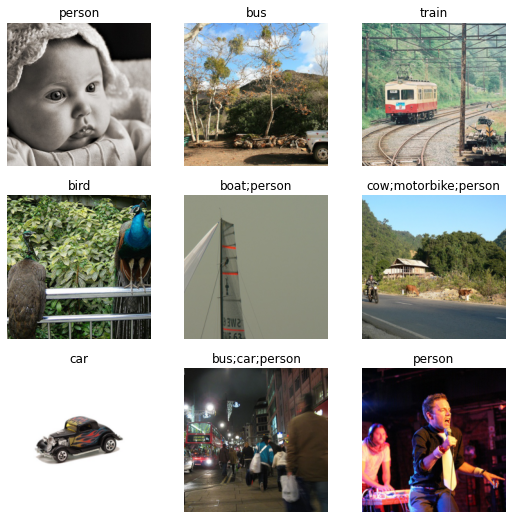

In [ ]:
dls.show_batch()

In [ ]:
multi_accuracy=partial(accuracy_multi, thresh=0.5)

In [ ]:
learner = cnn_learner(dls, resnet34, metrics=multi_accuracy, concat_pool=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


start fit


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=7.585775847473997e-07)

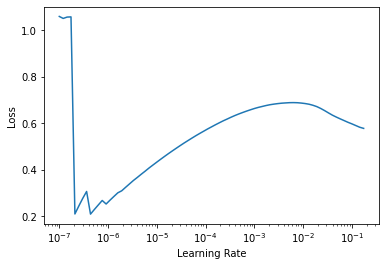

In [ ]:
learner.xla_lr_find(stop_div=False)
# learner.lr_find(stop_div=False)

In [ ]:
learner.xla_fine_tune(3, freeze_epochs=3, base_lr=1.4e-1)
# learner.fine_tune(3, freeze_epochs=3, base_lr=4e-2)

start fit


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.146336,0.610948,0.715386,01:00
1,0.119499,0.375640,0.890028,00:33
2,0.112388,0.558890,0.903921,00:29


start fit


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.063944,202.442871,0.881350,00:59
1,0.064911,5801.115723,0.886744,00:26
2,0.071089,84.886070,0.886744,00:24


In [ ]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learner.unfreeze()

start fit


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=7.585775847473997e-07)

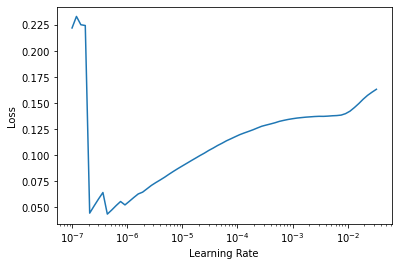

In [ ]:
learner.xla_lr_find()
# learner.lr_find()

In [ ]:
learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                      

In [ ]:
learner.xla_fit_one_cycle(5, lr_max=slice(2.2e-6, 2e-4))
# learner.fit_one_cycle(5, lr_max=slice(2.2e-6, 2e-4))

start fit


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.036333,4.914901,0.904220,01:04
1,0.038903,0.859600,0.921417,00:30
2,0.048053,0.343815,0.933718,00:21
3,0.059962,0.242719,0.937301,00:30
4,0.071667,0.213907,0.937838,00:23


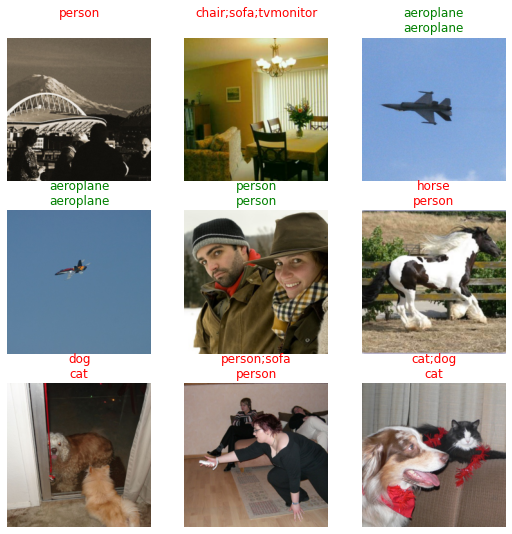

In [ ]:
learner.show_results()